In [1]:
import os
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from pathlib import Path
from heapq import nlargest
from datetime import timedelta
from collections import Counter
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
### path ###

data_path = Path('../input/otto-recommender-system')
train_path = data_path/'train.jsonl'
test_path = data_path/'test.jsonl'
sample_sub_path = Path('../input/otto-recommender-system/sample_submission.csv')

In [3]:
with open(train_path, 'r') as f:
    print(f"we have {len(f.readlines()):,} lines in the training data.")

we have 12,899,779 lines in the training data.


In [4]:
sample_size = 150000

chunks = pd.read_json(train_path, lines = True, chunksize = sample_size)

for c in chunks:
    sample_train_df = c
    break

In [5]:
sample_train_df.set_index('session', drop = True, inplace = True)
sample_train_df.head()


,events
session,
0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."


In [6]:
# sample the first session in the df
example_session = sample_train_df.iloc[0].item()
print(f'This session is {len(example_session)} actions long. \n')
print(f'The first action in the session: {example_session[0]}. \n')

# time of session
time_elapsed = example_session[-1]["ts"] - example_session[0]["ts"]
# time-stamp is in milliseconds since 00:00:00 UTC on 1 Jan 1970
print(f'The first session elapsed: {str(timedelta(milliseconds = time_elapsed))}. \n')

# count the frequency of actions within the session
action_counts = {}
for action in example_session:
    action_counts[action['type']] = action_counts.get(action['type'], 0) + 1
print(f'The first session contains the following frequency of actions: {action_counts}')

This session is 276 actions long. 

The first action in the session: {'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'}. 

The first session elapsed: 27 days, 13:09:43.682000. 

The first session contains the following frequency of actions: {'clicks': 255, 'carts': 17, 'orders': 4}


In [7]:
### Extract information from each session and add it to the df ###

action_counts_list, article_id_counts_list, session_length_time_list, session_length_action_list = ([] for i in range(4))
overall_action_counts = {}
overall_article_id_counts = {}

for i, row in tqdm(sample_train_df.iterrows(), total=len(sample_train_df)):
    
    actions = row['events']
    
    # Get the frequency of actions and article_ids
    action_counts = {}
    article_id_counts = {}
    for action in actions:
        action_counts[action['type']] = action_counts.get(action['type'], 0) + 1
        article_id_counts[action['aid']] = article_id_counts.get(action['aid'], 0) + 1
        overall_action_counts[action['type']] = overall_action_counts.get(action['type'], 0) + 1
        overall_article_id_counts[action['aid']] = overall_article_id_counts.get(action['aid'], 0) + 1
        
    # Get the length of the session
    session_length_time = actions[-1]['ts'] - actions[0]['ts']
    
    # Add to list
    action_counts_list.append(action_counts)
    article_id_counts_list.append(article_id_counts)
    session_length_time_list.append(session_length_time)
    session_length_action_list.append(len(actions))
    
sample_train_df['action_counts'] = action_counts_list
sample_train_df['article_id_counts'] = article_id_counts_list
sample_train_df['session_length_unix'] = session_length_time_list
sample_train_df['session_length_hours'] = sample_train_df['session_length_unix']*2.77778e-7  # Convert to hours
sample_train_df['session_length_action'] = session_length_action_list

  0%|          | 0/150000 [00:00<?, ?it/s]

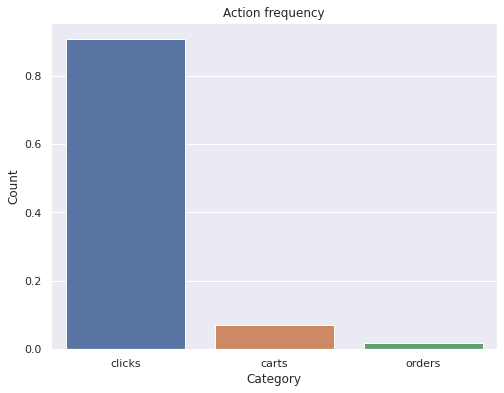

In [8]:
### Actions ###

total_actions = sum(overall_action_counts.values())

plt.figure(figsize=(8,6))
sns.barplot(x=list(overall_action_counts.keys()), y=[i/total_actions for i in overall_action_counts.values()])
plt.title(f'Action frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

Text(0.5, 1.0, 'Length of each session')

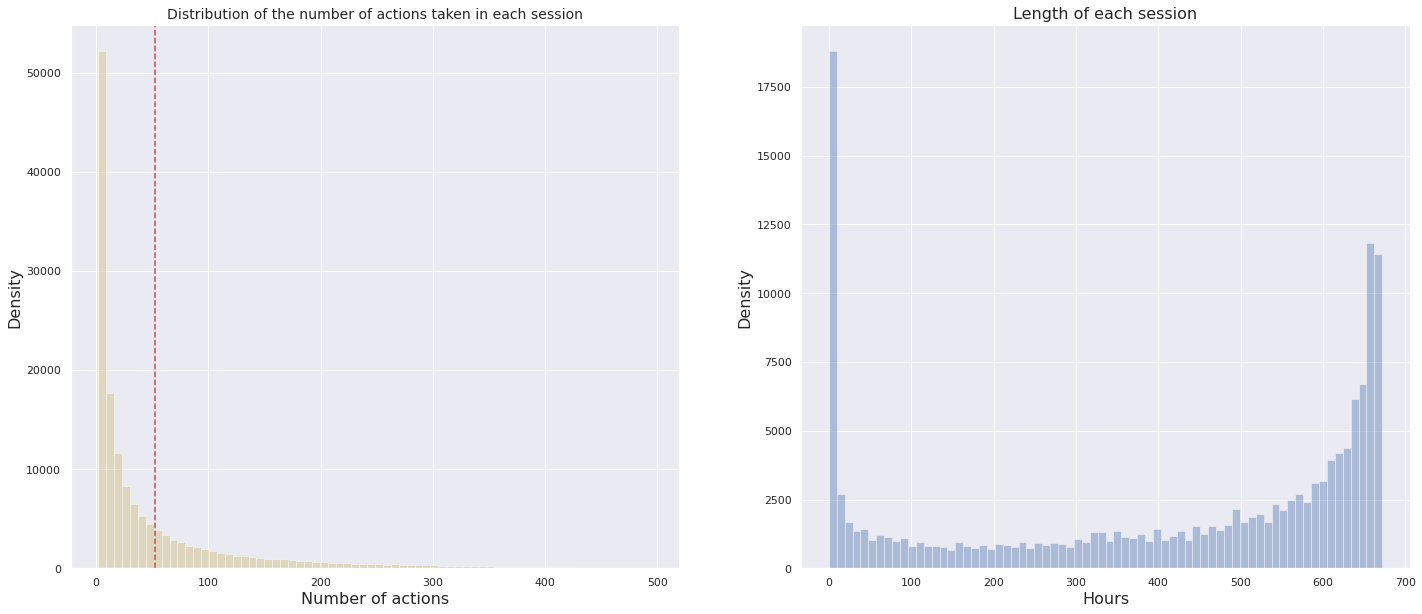

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (24, 10))

p = sns.distplot(sample_train_df['session_length_action'], color="y", bins=70, ax=ax[0], kde=False)
p.set_xlabel("Number of actions", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Distribution of the number of actions taken in each session", fontsize = 14)
p.axvline(sample_train_df['session_length_action'].mean(), color='r', linestyle='--', label="Mean")

p = sns.distplot(sample_train_df['session_length_hours'], color="b", bins= 70, ax=ax[1], kde=False)
p.set_xlabel("Hours", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Length of each session", fontsize = 16)

In [10]:
print(f'{round(len(sample_train_df[sample_train_df["session_length_action"]<10])/len(sample_train_df),3)*100}% of the sessions had less than 10 actions')

34.8% of the sessions had less than 10 actions


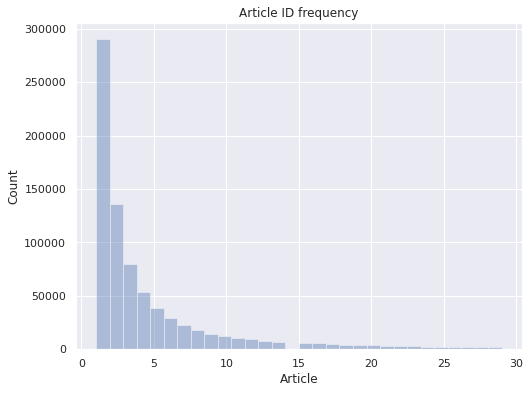

In [11]:
article_id_freq = list(overall_article_id_counts.values())
cut_off = [i for i in article_id_freq if i<30]

plt.figure(figsize=(8,6))
sns.distplot(cut_off, bins=30, kde=False);
plt.title(f'Article ID frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Article', fontsize=12);

In [12]:
### look at the most interacted with articles
print(f'Frequency of most common articles: {sorted(list(overall_article_id_counts.values()))[-5:]} \n')
res = nlargest(5, overall_article_id_counts, key = overall_article_id_counts.get)
print(f'IDs for those common articles: {res}')

Frequency of most common articles: [3877, 4259, 4323, 4503, 5000] 

IDs for those common articles: [29735, 1603001, 832192, 1733943, 108125]


In [13]:
import os
import gc
import heapq
import pickle
import numba as nb
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

tail = 30
parallel = 1024
topn = 20
ops_weights = np.array([1.0, 6.0, 3.0])
OP_WEIGHT = 0; TIME_WEIGHT = 1
parallel = 1024
test_ops_weights = np.array([1.0, 6.0, 3.0])

## Data
### Meta DataFrame
train.csv\test.csv columns:
- session: ordered session ids
- length: length of each session
- start_time: start time stamp (unit = 1sec) of this session

### Data Array
train.npz\test.csv:
An npz contains three 1-dim arrays:
- aids: aid array
- ts: time stamp array
- ops:type array,clicks=0, carts=1, orders=2

In [14]:
df = pd.read_csv("../input/otto-data/otto-data/train.csv")
df_test = pd.read_csv("../input/otto-data/otto-data/test.csv")
df = pd.concat([df, df_test]).reset_index(drop = True)
npz = np.load("../input/otto-data/otto-data/train.npz")
npz_test = np.load("../input/otto-data/otto-data/test.npz")
aids = np.concatenate([npz['aids'], npz_test['aids']])
ts = np.concatenate([npz['ts'], npz_test['ts']])
ops = np.concatenate([npz['ops'], npz_test['ops']])

df["idx"] = np.cumsum(df.length) - df.length
df["end_time"] = df.start_time + ts[df.idx + df.length - 1]

# Numba functions

To fully utilize the ability of numba's jit, and to avoid memory errors, we process `parallel=1024` sessions in one jit function call.

- Firstly, we count the `(aid1, aid2)` pairs in each session in parallel. 

- Then, we merge these pairs into a nested counter `{aid1: {aid2: n}, ...}`

- Finally, we find the top-k `aid2` from `aid1`'s counter

In [15]:
# get pair dict {(aid1, aid2): weight} for each session
# The maximum time span between two points is 1 day = 24 * 60 * 60 sec
@nb.jit(nopython = True, cache = True)
def get_single_pairs(pairs, aids, ts, ops, idx, length, start_time, ops_weights, mode):
    max_idx = idx + length
    min_idx = max(max_idx - tail, idx)
    for i in range(min_idx, max_idx):
        for j in range(i + 1, max_idx):
            if ts[j] - ts[i] >= 24 * 60 * 60: break
            if aids[i] == aids[j]: continue
            if mode == OP_WEIGHT:
                w1 = ops_weights[ops[j]]
                w2 = ops_weights[ops[i]]
            elif mode == TIME_WEIGHT:
                w1 = 1 + 3 * (ts[i] + start_time - 1659304800) / (1662328791 - 1659304800)
                w2 = 1 + 3 * (ts[j] + start_time - 1659304800) / (1662328791 - 1659304800)
            pairs[(aids[i], aids[j])] = w1
            pairs[(aids[j], aids[i])] = w2

# get pair dict of each session in parallel
# merge pairs into a nested dict format (cnt)
@nb.jit(nopython = True, parallel = True, cache = True)
def get_pairs(aids, ts, ops, row, cnts, ops_weights, mode):
    par_n = len(row)
    pairs = [{(0, 0): 0.0 for _ in range(0)} for _ in range(par_n)]
    for par_i in nb.prange(par_n):
        _, idx, length, start_time = row[par_i]
        get_single_pairs(pairs[par_i], aids, ts, ops, idx, length, start_time, ops_weights, mode)
    for par_i in range(par_n):
        for (aid1, aid2), w in pairs[par_i].items():
            if aid1 not in cnts: cnts[aid1] = {0: 0.0 for _ in range(0)}
            cnt = cnts[aid1]
            if aid2 not in cnt: cnt[aid2] = 0.0
            cnt[aid2] += w
    
# util function to get most common keys from a counter dict using min-heap
# overwrite == 1 means the later item with equal weight is more important
# otherwise, means the former item with equal weight is more important
# the result is ordered from higher weight to lower weight
@nb.jit(nopython = True, cache = True)
def heap_topk(cnt, overwrite, cap):
    q = [(0.0, 0, 0) for _ in range(0)]
    for i, (k, n) in enumerate(cnt.items()):
        if overwrite == 1:
            heapq.heappush(q, (n, i, k))
        else:
            heapq.heappush(q, (n, -i, k))
        if len(q) > cap:
            heapq.heappop(q)
    return [heapq.heappop(q)[2] for _ in range(len(q))][::-1]
   
# save top-k aid2 for each aid1's cnt
@nb.jit(nopython = True, cache = True)
def get_topk(cnts, topk, k):
    for aid1, cnt in cnts.items():
        topk[aid1] = np.array(heap_topk(cnt, 1, k))

# Train 
Here we use topk counting from [Deotte's notebooks](https://www.kaggle.com/code/cdeotte/candidate-rerank-model-lb-0-573). I dropped some of his ideas to make the whole pipeline simple but still strong.

- **mode 0**: Counters are weighted by operation types, with `op_weights = [1.0, 6.0, 3.0]`. This will be used for carts and orders prediction.

- **mode 1**: Counters are weighted by operation time.  This will be used for clicks prediction.

For each mode, the eastimated running time is **7min~8min** in kaggle notebook

In [16]:
topks = {}

# for two modes
for mode in [OP_WEIGHT, TIME_WEIGHT]:
    # get nested counter
    cnts = nb.typed.Dict.empty(
        key_type = nb.types.int64,
        value_type = nb.typeof(nb.typed.Dict.empty(key_type = nb.types.int64, value_type = nb.types.float64)))
    max_idx = len(df)
    for idx in tqdm(range(0, max_idx, parallel)):
        row = df.iloc[idx:min(idx + parallel, max_idx)][['session', 'idx', 'length', 'start_time']].values
        get_pairs(aids, ts, ops, row, cnts, ops_weights, mode)

    # get topk from counter
    topk = nb.typed.Dict.empty(
            key_type = nb.types.int64,
            value_type = nb.types.int64[:])
    get_topk(cnts, topk, topn)

    del cnts; gc.collect()
    topks[mode] = topk

  0%|          | 0/14231 [00:00<?, ?it/s]

  0%|          | 0/14231 [00:05<?, ?it/s]

# Inference Numba Functions
### Inference Numba Functions

The logic is a simpler version of [Deotte's notebook](https://www.kaggle.com/code/cdeotte/candidate-rerank-model-lb-0-573).

Same as training functions, we process `parallel=1024` sessions in one jit function call. For each session, if the unique aids is more than 20, we rerank them by a time-decay weight. Otherwise, we use current aids to recall new aids from their topk co-visitation candidates, weighted by the query's operation type (`test_ops_weights=[1.0, 6.0, 3.0]`). 

We used **mode0** topk to generate predictions for carts and orders, and **mode1** topk to generate predictions for clicks. 

In [17]:
@nb.jit(nopython = True, cache = True)
def inference_(aids, ops, row, result, topk, test_ops_weights, seq_weight):
    for session, idx, length in row:
        unique_aids = nb.typed.Dict.empty(key_type = nb.types.int64, value_type = nb.types.float64)
        cnt = nb.typed.Dict.empty(key_type = nb.types.int64, value_type = nb.types.float64)
        
        candidates = aids[idx:idx + length][::-1]
        candidates_ops = ops[idx:idx + length][::-1]
        for a in candidates:
            unique_aids[a] = 0
                
        if len(unique_aids) >= 20:
            sequence_weight = np.power(2, np.linspace(seq_weight, 1, len(candidates)))[::-1] - 1
            for a, op, w in zip(candidates, candidates_ops, sequence_weight):
                if a not in cnt: cnt[a] = 0
                cnt[a] += w * test_ops_weights[op]
            result_candidates = heap_topk(cnt, 0, 20)
        else:
            result_candidates = list(unique_aids)
            for a in result_candidates:
                if a not in topk: continue
                for b in topk[a]:
                    if b in unique_aids: continue
                    if b not in cnt: cnt[b] = 0
                    cnt[b] += 1
            result_candidates.extend(heap_topk(cnt, 0, 20 - len(result_candidates)))
        result[session] = np.array(result_candidates)
        
@nb.jit(nopython = True)
def inference(aids, ops, row, 
              result_clicks, result_buy,
              topk_clicks, topk_buy,
              test_ops_weights):
    inference_(aids, ops, row, result_clicks, topk_clicks, test_ops_weights, 0.1)
    inference_(aids, ops, row, result_buy, topk_buy, test_ops_weights, 0.5)

In [18]:
# result place holder
result_clicks = nb.typed.Dict.empty(
    key_type = nb.types.int64,
    value_type = nb.types.int64[:])
result_buy = nb.typed.Dict.empty(
    key_type = nb.types.int64,
    value_type = nb.types.int64[:])
for idx in tqdm(range(len(df) - len(df_test), len(df), parallel)):
    row = df.iloc[idx:min(idx + parallel, len(df))][['session', 'idx', 'length']].values
    inference(aids, ops, row, result_clicks, result_buy, topks[TIME_WEIGHT], topks[OP_WEIGHT], test_ops_weights)

  0%|          | 0/1633 [00:00<?, ?it/s]

In [19]:
subs = []
op_names = ["clicks", "carts", "orders"]
for result, op in zip([result_clicks, result_buy, result_buy], op_names):

    sub = pd.DataFrame({"session_type": result.keys(), "labels": result.values()})
    sub.session_type = sub.session_type.astype(str) + f"_{op}"
    sub.labels = sub.labels.apply(lambda x: " ".join(x.astype(str)))
    subs.append(sub)
    
sub = pd.concat(subs).reset_index(drop = True)
sub.to_csv('submission.csv', index = False)
sub.head()

,session_type,labels
0,12899779_clicks,59625 1253524 737445 438191 731692 1790770 166...
1,12899780_clicks,1142000 736515 973453 582732 1502122 889686 48...
2,12899781_clicks,918667 199008 194067 57315 141736 1460571 7594...
3,12899782_clicks,834354 595994 740494 889671 987399 779477 1344...
4,12899783_clicks,1817895 607638 1754419 1216820 1729553 300127 ...
